In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
# display settings to show all columns
pd.set_option('display.max_columns', None)
# display settings to show full text in columns
pd.set_option('display.max_colwidth', None)

### Model run on 7/2/2024 using split_SMOTE_crossval.py

In [2]:
# Load results
model_results = pd.read_csv('split_SMOTE_crossval_results.csv')
#model_results.columns

In [3]:
# Load predictions
model_predictions = pd.read_csv('bequest_prediciton_alive_20240702.csv')
#model_predictions.columns

In [4]:
# Load full dataset used for training and testing
bequests_clean = pd.read_csv('bequests_clean.csv')
#bequests_clean.columns

In [5]:
# Count unique ROI_FAMILY_IDs in the model results
model_predictions['ROI_FAMILY_ID'].nunique()

1376

In [6]:
# Count unique ROI_FAMILY_IDs in the full dataset
bequests_clean['ROI_FAMILY_ID'].nunique()

4520004

### Identify all "alive" bequestors

In [7]:
# Unique bequests_clean['ROI_FAMILY_ID'] where 'BEQUEST_RECEIVED' = 1 and DEATH_FLAG = 0
bequests_clean[(bequests_clean['BEQUEST_RECEIVED'] == 1) & 
               (bequests_clean['DEATH_FLAG'] == 0)]['ROI_FAMILY_ID'].nunique()

33

In [8]:
# Create list of unique ROI_FAMILY_IDs where 'BEQUEST_RECEIVED' = 1 and DEATH_FLAG = 0
bequest_alive = bequests_clean[(bequests_clean['BEQUEST_RECEIVED'] == 1) & 
                                (bequests_clean['DEATH_FLAG'] == 0)]['ROI_FAMILY_ID'].unique()

### How many "alive" bequestors were found by the model?

In [9]:
# How many unique ROI_FAMILY_IDs are in both model_predictions and bequest_alive
len(set(model_predictions['ROI_FAMILY_ID']).intersection(set(bequest_alive)))

30

### What was the observed recall?

In [10]:
30/33

0.9090909090909091

### Mark the predicted bequestors in the bequests_clean dataset

In [11]:
# Create bequests_clean['FUTURE_BEQUESTOR'] = 1 when model_predictions['ROI_FAMILY_ID'] is in bequests_clean['ROI_FAMILY_ID']
bequests_clean['FUTURE_BEQUESTOR'] = bequests_clean['ROI_FAMILY_ID'].isin(model_predictions['ROI_FAMILY_ID']).astype(int)

### Restructure report df to describe modeling metrics

In [12]:
# Function to flatten a JSON column (classification_report)
def flatten_json_column(df, column):
    # Parse the JSON data
    json_data = df[column].apply(json.loads)
    # Create a new DataFrame with the flattened data
    json_df = pd.json_normalize(json_data)
    # Concatenate the original DataFrame with the new flattened DataFrame
    df = pd.concat([df, json_df], axis=1)
    # Drop the original JSON column
    df.drop(column, axis=1, inplace=True)
    return df

In [13]:
# List of columns containing JSON arrays to be flattened
json_columns = ['classification_report']

In [14]:
# Flatten each JSON column
for column in json_columns:
    model_results = flatten_json_column(model_results, column)

In [15]:
# Function to flatten the feature_importance column
def flatten_feature_importance(df, column):
    # Parse the JSON data
    flattened_data = []
    for entry in df[column]:
        try:
            feature_data = json.loads(entry.replace("'", '"'))
            flattened_row = {}
            for idx, (feature, importance) in enumerate(zip(feature_data['Feature'], feature_data['Importance'])):
                flattened_row[f"feature_{idx+1}"] = feature
                flattened_row[f"feature_{idx+1}_score"] = importance
            flattened_data.append(flattened_row)
        except json.JSONDecodeError:
            print(f"Failed to parse JSON: {entry}")
            flattened_data.append({})
    # Convert the flattened data into a DataFrame
    feature_df = pd.DataFrame(flattened_data)
    # Concatenate the original DataFrame with the new flattened DataFrame
    df = pd.concat([df, feature_df], axis=1)
    # Drop the original feature_importance column
    df.drop(column, axis=1, inplace=True)
    return df


In [16]:
# Flatten the feature_importance column
model_results = flatten_feature_importance(model_results, 'feature_importance')

In [17]:
# Display results where imputer = 'mice'
model_results[model_results['imputer'] == 'mice']

,imputer,accuracy,auc_pr,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support,feature_1,feature_1_score,feature_2,feature_2_score,feature_3,feature_3_score,feature_4,feature_4_score,feature_5,feature_5_score,feature_6,feature_6_score,feature_7,feature_7_score,feature_8,feature_8_score,feature_9,feature_9_score,feature_10,feature_10_score,feature_11,feature_11_score,feature_12,feature_12_score,feature_13,feature_13_score,feature_14,feature_14_score,feature_15,feature_15_score,feature_16,feature_16_score,feature_17,feature_17_score,feature_18,feature_18_score,feature_19,feature_19_score
2,mice,0.998411,0.880103,0.998411,0.999521,0.998884,0.999202,94057.0,0.755814,0.878378,0.8125,370.0,0.877668,0.938631,0.905851,94427.0,0.998566,0.998411,0.998471,94427.0,HPC_AMOUNT,0.228298,MRC_AMOUNT,0.201433,YEARS_SINCE_HPC_GIFT,0.146419,TOTAL_AMOUNT,0.143256,YEARS_SINCE_MRC_GIFT,0.112135,YEARS_SINCE_FIRST_GIFT,0.039562,FIRST_GIFT_AMOUNT,0.038579,TOTAL_TRANSACTIONS,0.034014,BIRTH_YEAR,0.027341,REGION_CODE_PARO,0.003979,REGION_CODE_MARO,0.003973,REGION_CODE_MWRO,0.003866,REGION_CODE_NERO,0.003536,REGION_CODE_SWRO,0.003177,REGION_CODE_SERO,0.002632,REGION_CODE_SCRO,0.002519,REGION_CODE_TXRO,0.001848,REGION_CODE_NWRO,0.001833,REGION_CODE_NRRO,0.001599


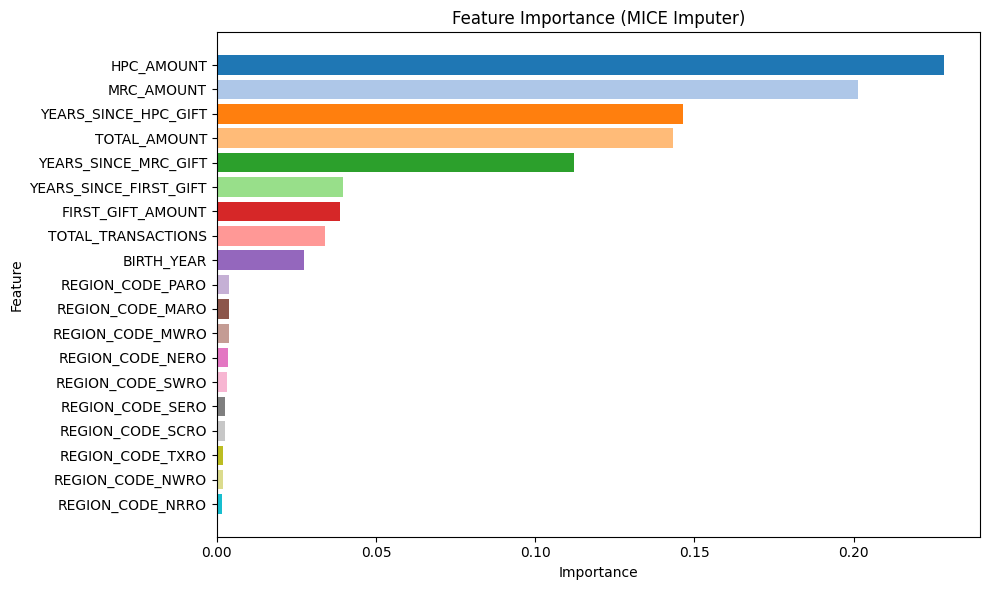

In [18]:
# Data for feature importance from the MICE imputer
data = {
    'Feature': ['HPC_AMOUNT', 'MRC_AMOUNT', 'YEARS_SINCE_HPC_GIFT', 'TOTAL_AMOUNT', 'YEARS_SINCE_MRC_GIFT',
                'YEARS_SINCE_FIRST_GIFT', 'FIRST_GIFT_AMOUNT', 'TOTAL_TRANSACTIONS', 'BIRTH_YEAR', 
                'REGION_CODE_PARO', 'REGION_CODE_MARO', 'REGION_CODE_MWRO', 'REGION_CODE_NERO', 
                'REGION_CODE_SWRO', 'REGION_CODE_SERO', 'REGION_CODE_SCRO', 'REGION_CODE_TXRO', 
                'REGION_CODE_NWRO', 'REGION_CODE_NRRO'],
    'Importance': [0.228298, 0.201433, 0.146419, 0.143256, 0.112135, 0.039562, 0.038579, 0.034014, 
                   0.027341, 0.003979, 0.003973, 0.003866, 0.003536, 0.003177, 0.002632, 0.002519, 
                   0.001848, 0.001833, 0.001599]
}

mice_results = pd.DataFrame(data)

# Create a custom palette with 11 colors from the icefire palette
custom_palette = sns.color_palette("tab20", 20)

# Use the custom color palette
sns.set_palette(custom_palette)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(mice_results['Feature'], mice_results['Importance'], color=custom_palette)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (MICE Imputer)')
plt.gca().invert_yaxis()
plt.tight_layout()

### Summarize info about predicted future bequestors

In [19]:
# Create subset of bequests_clean showing just FUTURE_BEQUESTOR = 1
bequests_clean_future_bequestors = bequests_clean[bequests_clean['FUTURE_BEQUESTOR'] == 1]

In [20]:
# Percentage of blank values in each column
bequests_clean_future_bequestors.isnull().mean().sort_values(ascending=False)

BIRTH_YEAR                0.124909
ROI_ID                    0.000000
DEATH_FLAG                0.000000
LE                        0.000000
BEQUEST_RECEIVED          0.000000
YEARS_SINCE_HPC_GIFT      0.000000
YEARS_SINCE_MRC_GIFT      0.000000
YEARS_SINCE_FIRST_GIFT    0.000000
HPC_AMOUNT                0.000000
ROI_FAMILY_ID             0.000000
MRC_AMOUNT                0.000000
FIRST_GIFT_AMOUNT         0.000000
TOTAL_AMOUNT              0.000000
TOTAL_TRANSACTIONS        0.000000
REGION_CODE               0.000000
STATE                     0.000000
FUTURE_BEQUESTOR          0.000000
dtype: float64

In [21]:
# Create AGE column in bequests_clean_future_bequestor BIRTH_YEAR
# Ensure bequests_clean_future_bequestors is a standalone DataFrame to avoid SettingWithCopyWarning
bequests_clean_future_bequestors = bequests_clean_future_bequestors.copy()
# Create AGE column
bequests_clean_future_bequestors['AGE'] = 2024 - bequests_clean_future_bequestors['BIRTH_YEAR']

In [22]:
# Drop records where DEATH_FLAG = 1
bequests_clean_future_bequestors = bequests_clean_future_bequestors[bequests_clean_future_bequestors['DEATH_FLAG'] == 0]

In [23]:
# Drop records where AGE is greater than 85
bequests_clean_future_bequestors = bequests_clean_future_bequestors[bequests_clean_future_bequestors['AGE'] <= 85]

In [24]:
# Set display options to avoid scientific notation and round values
pd.set_option('display.float_format', '{:.2f}'.format)

print("Number of predicted future bequestors:", bequests_clean_future_bequestors['ROI_FAMILY_ID'].nunique())
print("Predicted future bequestors summary:")
summary = bequests_clean_future_bequestors[['HPC_AMOUNT', 'MRC_AMOUNT', 'YEARS_SINCE_HPC_GIFT',
                                            'TOTAL_AMOUNT', 'YEARS_SINCE_MRC_GIFT', 'YEARS_SINCE_FIRST_GIFT',
                                            'FIRST_GIFT_AMOUNT', 'TOTAL_TRANSACTIONS', 'AGE']].describe()
# summary but drop the count row
summary.drop('count', axis=0, inplace=True)
summary

Number of predicted future bequestors: 1019
Predicted future bequestors summary:


,HPC_AMOUNT,MRC_AMOUNT,YEARS_SINCE_HPC_GIFT,TOTAL_AMOUNT,YEARS_SINCE_MRC_GIFT,YEARS_SINCE_FIRST_GIFT,FIRST_GIFT_AMOUNT,TOTAL_TRANSACTIONS,AGE
mean,17537.72,7829.05,3.10,85546.73,1.98,16.16,2131.21,18.20,68.74
std,59532.58,22394.29,3.37,521091.79,2.86,11.35,6441.81,23.11,12.18
min,420.00,10.00,0.00,600.00,0.00,0.00,5.00,1.00,29.00
25%,2500.00,2000.00,0.00,5000.00,0.00,7.00,25.00,3.00,62.00
50%,5000.00,2500.00,2.00,10932.00,1.00,12.00,50.00,10.00,72.00
75%,10000.00,5000.00,5.00,33106.25,3.00,27.00,1262.50,25.00,78.00
max,993532.50,480000.00,24.00,13796611.00,12.00,41.00,82390.72,229.00,85.00


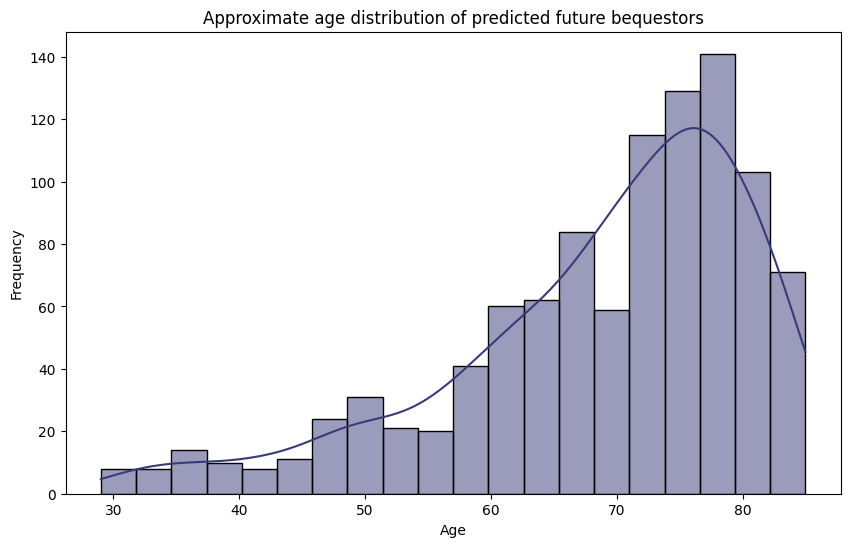

In [25]:
# Define colors
hist_color = '#393b79'  

# Plot age distribution of predicted future bequestors
plt.figure(figsize=(10, 6))
sns.histplot(bequests_clean_future_bequestors['AGE'], bins=20, kde=True, 
             color=hist_color)
plt.title('Approximate age distribution of predicted future bequestors')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()



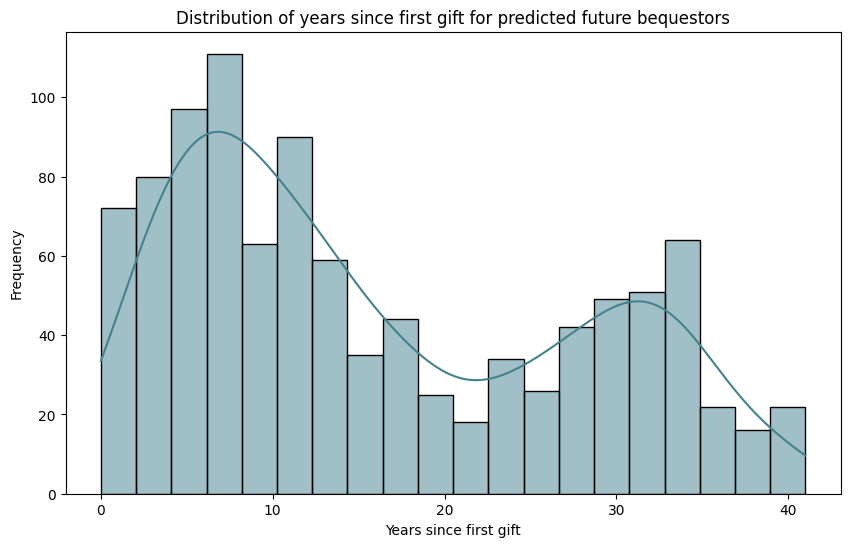

In [26]:
# Define colors
hist_color = '#45818e'  

# Plot age distribution of predicted future bequestors
plt.figure(figsize=(10, 6))
sns.histplot(bequests_clean_future_bequestors['YEARS_SINCE_FIRST_GIFT'], bins=20, kde=True, 
             color=hist_color)
plt.title('Distribution of years since first gift for predicted future bequestors')
plt.xlabel('Years since first gift')
plt.ylabel('Frequency')
plt.show()


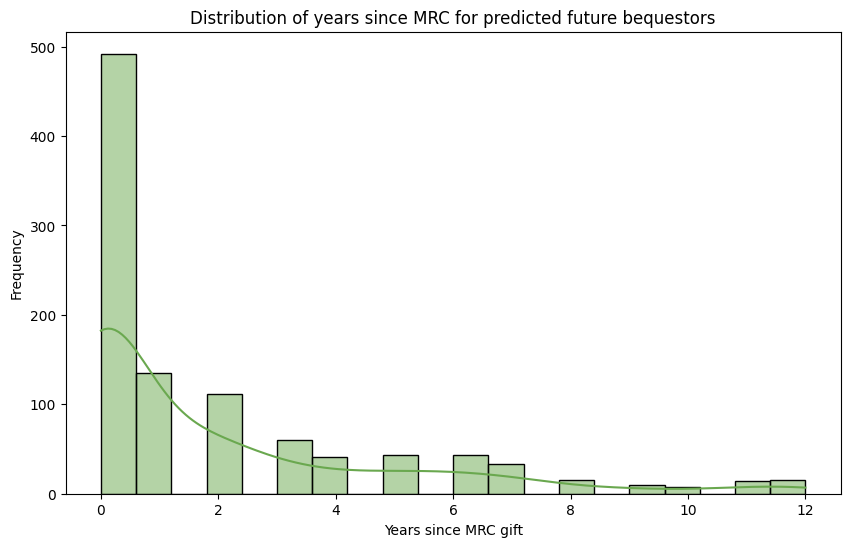

In [27]:
# Define colors
hist_color = '#6aa84f'  

# Plot age distribution of predicted future bequestors
plt.figure(figsize=(10, 6))
sns.histplot(bequests_clean_future_bequestors['YEARS_SINCE_MRC_GIFT'], bins=20, kde=True, 
             color=hist_color)
plt.title('Distribution of years since MRC for predicted future bequestors')
plt.xlabel('Years since MRC gift')
plt.ylabel('Frequency')
plt.show()

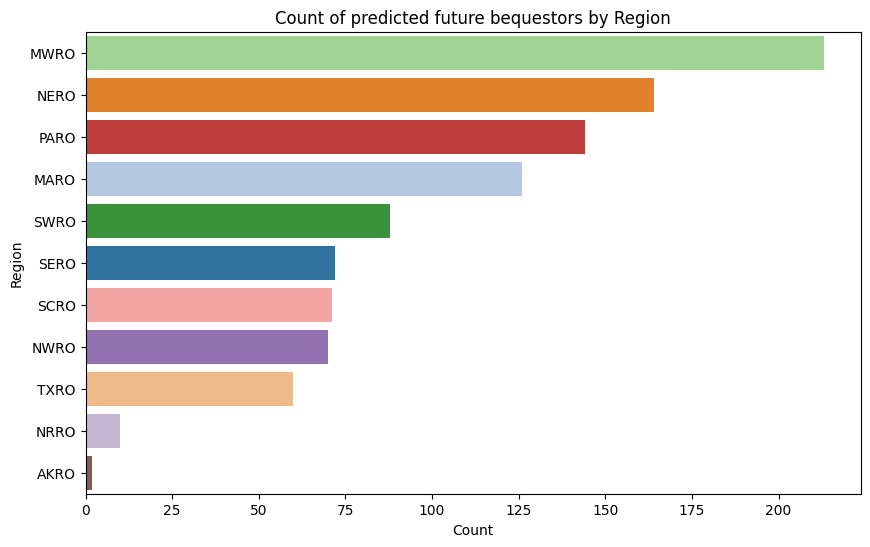

In [28]:
# Show Frequency of predicted future bequestors by STATE 

# Create a custom palette with 11 colors from the icefire palette
custom_palette = sns.color_palette("tab20", 11)

# Use the custom color palette
sns.set_palette(custom_palette)

plt.figure(figsize=(10, 6))
sns.countplot(y='REGION_CODE', data=bequests_clean_future_bequestors, 
              order=bequests_clean_future_bequestors['REGION_CODE'].value_counts().index,
              palette=custom_palette, hue='REGION_CODE')
plt.title('Count of predicted future bequestors by Region')
plt.xlabel('Count')
plt.ylabel('Region')
plt.show()

In [29]:
# Write bequests_clean_future_bequestors to a CSV file
bequests_clean_future_bequestors.to_csv('bequests_clean_future_bequestors.csv', index=False)

### Explanation of PR AUC

The Precision-Recall Area Under the Curve (PR AUC) is a crucial metric for evaluating models on imbalanced datasets like this one, where the number of bequestors (positive class) is significantly smaller than non-bequestors (negative class). PR AUC focuses on the performance with respect to the positive class (bequestors), making it more informative than accuracy in this context.

Precision is the ratio of true positive predictions to the total number of positive predictions made by the model (true positives + false positives).

Recall is the ratio of true positive predictions to the actual number of positive instances in the dataset (true positives + false negatives).

By plotting precision against recall at various threshold settings, we obtain the Precision-Recall curve. The area under this curve (PR AUC) provides a single metric to summarize the model's ability to correctly identify bequestors. A PR AUC of 0.88 indicates that the model has a high capability to distinguish between bequestors and non-bequestors, balancing the trade-off between precision and recall effectively.

### Conclusion
The models with different imputation methods performed exceptionally well, with perfect accuracy and high PR AUC. The consistency in feature importance highlights the robustness of the predictors identified. The PR AUC of 0.88 underscores the model's effectiveness in identifying bequestors within an imbalanced dataset, making it a valuable tool for future donor analysis and prediction efforts.